In [4]:
import jax
import jax.numpy as jnp
# from flax import linen as nn
# import optax
from typing import Callable, Tuple, Any
import numpy as np
from functools import partial
import pdb
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn

In [5]:
# Load the MNIST dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_train, Y_train, X_test, Y_test = jnp.expand_dims(jnp.array(X_train/255), axis=-1), jnp.expand_dims(jnp.array(Y_train), axis=-1), jnp.expand_dims(jnp.array(X_test/255), axis=-1), jnp.expand_dims(jnp.array(Y_test), axis=-1)

X_train = (X_train > 0.5).astype(jnp.float32)
X_test = (X_test > 0.5).astype(jnp.float32)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# --- 1. The Energy-Based Model (RBM) ---
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.lr = learning_rate

        # Initialize weights with small random values
        # W shape: (n_visible, n_hidden)
        self.W = jax.random.normal(jax.random.PRNGKey(45), (n_visible, n_hidden)) #(0, 0.01, (n_visible, n_hidden))
        self.v_bias = jnp.zeros(n_visible)
        self.h_bias = jnp.zeros(n_hidden)

        # Monitoring
        self.errors = []

    def sigmoid(self, x):
        return 1.0 / (1.0 + jnp.exp(-x))

    def sample_hidden(self, v):
        """
        Block Gibbs Step: P(h|v)
        """
        # Calculate activation energy
        print(v.shape, self.W.shape)
        activation = jnp.dot(v, self.W) + self.h_bias
        prob_h = self.sigmoid(activation)
        # Stochastic sampling (Bernoulli)
        return prob_h, jax.random.binomial(jax.random.PRNGKey(397), 1, prob_h)

    def sample_visible(self, h):
        """
        Block Gibbs Step: P(v|h)
        """
        # Calculate activation energy
        activation = jnp.dot(h, self.W.T) + self.v_bias
        prob_v = self.sigmoid(activation)
        # Stochastic sampling (Bernoulli)
        return prob_v, jax.random.binomial(jax.random.PRNGKey(16), 1, prob_v)

    def contrastive_divergence(self, v0):
        """
        The training algorithm (CD-1).
        Approximates the gradient of the Energy function.
        """
        # --- Positive Phase (Data Driven) ---
        # 1. Pass data up to hidden layer
        prob_h0, h0 = self.sample_hidden(v0)

        # --- Negative Phase (Model Daydreaming / Block Gibbs) ---
        # 2. Reconstruct visible (Block Gibbs down)
        prob_v1, v1 = self.sample_visible(h0)
        # 3. Sample hidden again (Block Gibbs up)
        prob_h1, h1 = self.sample_hidden(v1)

        # --- Update Weights (Gradient Descent on Energy) ---
        # Contrastive Divergence: <v0*h0> - <v1*h1>
        batch_size = v0.shape[0]

        positive_grad = jnp.dot(v0.T, prob_h0)
        negative_grad = jnp.dot(v1.T, prob_h1)

        # Update W, biases
        self.W += self.lr * (positive_grad - negative_grad) / batch_size
        self.v_bias += self.lr * jnp.mean(v0 - v1, axis=0)
        self.h_bias += self.lr * jnp.mean(prob_h0 - prob_h1, axis=0)

        # Track reconstruction error (MSE) for visualization
        error = jnp.mean((v0 - v1) ** 2)
        return error

    def transform(self, v):
        """
        Transform raw input into hidden feature representation.
        Returns the probability of hidden units being active.
        """
        prob_h, _ = self.sample_hidden(v)
        return prob_h


In [10]:
# --- 3. Training the PGM (Unsupervised) ---
print("Training RBM (Generative Phase)...")
n_hidden_units = 128
rbm = RBM(n_visible=784, n_hidden=n_hidden_units, learning_rate=0.1)

epochs = 10
batch_size = 64
n_batches = X_train.shape[0] // batch_size

for epoch in range(epochs):
    epoch_error = 0
    # Shuffle data
    indices = np.random.permutation(X_train.shape[0])

    for i in range(0, X_train.shape[0], batch_size):
        batch_idx = indices[i:i+batch_size]
        batch = X_train[batch_idx]

        # Skip incomplete batches
        if len(batch) < batch_size: continue

        err = rbm.contrastive_divergence(batch)
        epoch_error += err

    avg_error = epoch_error / n_batches
    print(f"Epoch {epoch+1}/{epochs} - Reconstruction Error: {avg_error:.4f}")

Training RBM (Generative Phase)...
(64, 28, 28, 1) (784, 128)


TypeError: dot_general requires contracting dimensions to have the same shape, got (1,) and (784,).

In [11]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X = mnist.data
X.shape

(70000, 784)

In [15]:
X_train.shape

(60000, 28, 28, 1)

In [1]:
import networkx as nx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

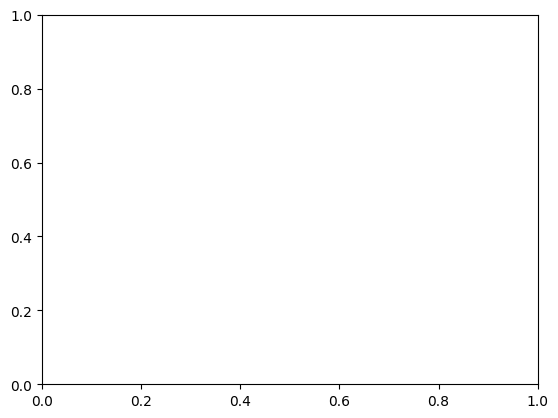

In [17]:
side_length = 20

# in this simple example we will just use a basic grid, although THRML is capable of dealing with arbitrary graph topologies
G = nx.grid_graph(dim=(side_length, side_length), periodic=False)

# # label the nodes with something THRML recognizes for convenience
# coord_to_node = {coord: CategoricalNode() for coord in G.nodes}
# nx.relabel_nodes(G, coord_to_node, copy=False)
# for coord, node in coord_to_node.items():
#     G.nodes[node]["coords"] = coord

# write down the color groups for later
bicol = nx.bipartite.color(G)
color0 = [n for n, c in bicol.items() if c == 0]
color1 = [n for n, c in bicol.items() if c == 1]

# write down the edges in a different format for later
u, v = map(list, zip(*G.edges()))

# plot the graph
pos = {n: G.nodes[n] for n in G.nodes}
colors = ["black", "orange"]
node_colors = [colors[bicol[n]] for n in G.nodes]

fig, axs = plt.subplots()

nx.draw(
    G,
    pos=pos,
    ax=axs,
    node_size=50.0,
    node_color=node_colors,
    edgecolors="k",
    with_labels=False,
)

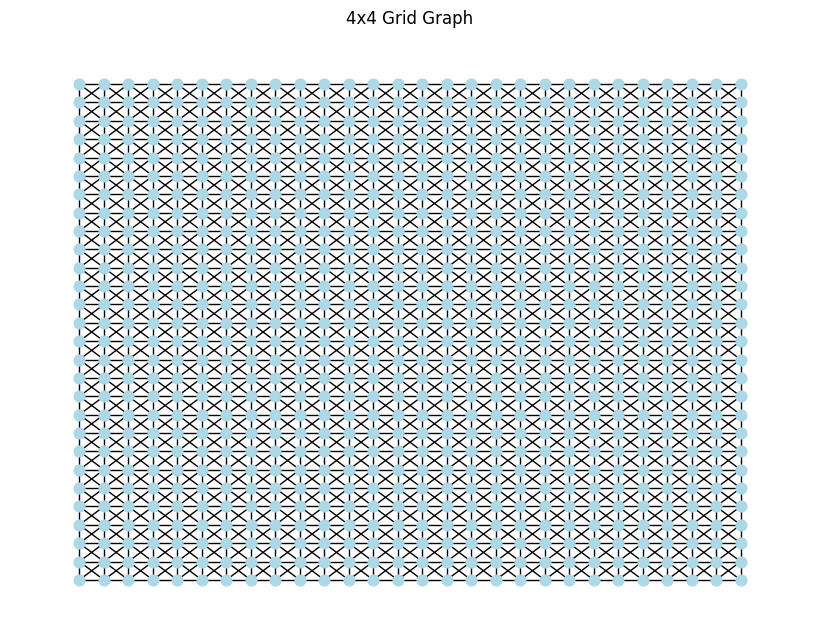

In [4]:
h,w = 28,28

G = nx.grid_2d_graph(h,w)
# 3. specific layout for visualization
# Since nodes are tuples (x, y), we can use them directly as coordinates
# to make the plot look like a proper grid.

for r, c in G.nodes():
    if r-1>=0 and c-1>=0:
        G.add_edge((r, c), (r-1, c-1))
    if r-1>=0 and c+1<w:
        G.add_edge((r, c), (r-1, c+1))
    if r+1<h and c-1>=0:
        G.add_edge((r, c), (r+1, c-1))
    if r+1<h and c+1<w:
        G.add_edge((r, c), (r+1, c+1))

pos = dict((n, n) for n in G.nodes())

# 4. Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(
    G, 
    pos=pos, 
    with_labels=False, 
    node_color='lightblue', 
    node_size=60,
    font_size=10
)
plt.title(f"{4}x{4} Grid Graph")
plt.show()

In [ ]:
# write down the edges in a different format for later
u, v = map(list, zip(*G.edges()))
# how many categories to use for each variable
n_cats = 5

# temperature parameter
beta = 1.0


# implements W^{2} for each edge
# in this case we are just using an identity matrix, but this could be anything
id_mat = jnp.eye(n_cats)
weights = beta * jnp.broadcast_to(jnp.expand_dims(id_mat, 0), (len(u), *id_mat.shape))

In [19]:
len(u)

2970

In [2]:
import thrml
# from thrml.data import mnist
from thrml.train import Trainer
from thrml.models.pgm import NaiveBayes
import numpy as np

# ------------------------------------------------------------
# Load MNIST
# ------------------------------------------------------------
(train_x, train_y), (test_x, test_y) = mnist.load()

train_x = train_x.astype(np.float32) / 255.0
test_x = test_x.astype(np.float32) / 255.0

train_x = train_x.reshape(-1, 28 * 28)
test_x = test_x.reshape(-1, 28 * 28)

# ------------------------------------------------------------
# Build probabilistic graphical model
# ------------------------------------------------------------
model = NaiveBayes(
    input_dim=28 * 28,
    num_classes=10
)

# ------------------------------------------------------------
# Trainer
# ------------------------------------------------------------
trainer = Trainer(
    model=model,
    criterion=None,        # NaiveBayes uses likelihood, no loss needed
    optimizer=None,        # No gradient descent needed
    batch_size=256,
    epochs=1               # One pass is enough for this model
)

# ------------------------------------------------------------
# Fit
# ------------------------------------------------------------
trainer.fit(train_x, train_y)

# ------------------------------------------------------------
# Evaluate
# ------------------------------------------------------------
pred = trainer.predict(test_x)
accuracy = (pred.argmax(axis=1) == test_y).mean()

print("Test accuracy:", accuracy)


ModuleNotFoundError: No module named 'thrml.train'

In [3]:
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit
import torch  # For loading MNIST (assuming available; alternatively use optax for optimizers)
from torch.utils.data import DataLoader
from sklearn.datasets import fetch_openml
from thrml import SpinNode, Block, SamplingSchedule, sample_states
from thrml.models import IsingEBM, IsingSamplingProgram, hinton_init
from sklearn.linear_model import LogisticRegression  # For final classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Hyperparameters
num_visible = 784  # MNIST image size (28x28 flattened)
num_hidden = 500
batch_size = 128
learning_rate = 0.01
num_epochs = 10
beta = jnp.array(1.0)  # Inverse temperature
cd_steps = 1  # CD-1 for contrastive divergence
key = jax.random.PRNGKey(809)

# Load MNIST dataset (binarized)
print("Fetching MNIST data... (this might take a moment)")
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X = mnist.data
y = mnist.target.astype(int)

# Normalize to [0, 1]
X = X / 255.0

# Binarize the data (Bernoulli RBMs require binary inputs)
# Pixels > 0.5 become 1, else 0
X = jnp.array((X > 0.5).astype(jnp.float32) * 2 - 1)

# Split Training/Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: (x > 0.5).float() * 2 - 1)])  # Binarize to -1/1
# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define nodes: visible (image pixels) and hidden
visible_nodes = [SpinNode() for _ in range(num_visible)]
hidden_nodes = [SpinNode() for _ in range(num_hidden)]
all_nodes = visible_nodes + hidden_nodes

# Define bipartite edges: connect each visible to each hidden
edges = [(v, h) for v in visible_nodes for h in hidden_nodes]

# Initialize parameters (biases and weights)
key = random.key(0)
k_bias_v, k_bias_h, k_weights = random.split(key, 3)
visible_biases = random.normal(k_bias_v, (num_visible,)) * 0.01
hidden_biases = random.normal(k_bias_h, (num_hidden,)) * 0.01
weights = random.normal(k_weights, (len(edges),)) * 0.01  # One weight per edge

# Create the EBM model
model = IsingEBM(all_nodes, edges, jnp.concatenate([visible_biases, hidden_biases]), weights, beta)

# Define blocks for block Gibbs: visible and hidden as separate blocks for alternating sampling
visible_block = Block(visible_nodes)
hidden_block = Block(hidden_nodes)
free_blocks = [visible_block, hidden_block]  # Alternate between visible and hidden

# Sampling program
program = IsingSamplingProgram(model, free_blocks, clamped_blocks=[])

# Function to compute hidden probabilities given visible (positive phase)
def hidden_prob(visible_states):
    # Compute energies for hidden given visible (vectorized)
    hid_logits = hidden_biases + jnp.einsum('i,ji->j', visible_states, weights.reshape(num_visible, num_hidden))
    return jax.nn.sigmoid(beta * hid_logits)

# Function to compute visible probabilities given hidden (reconstruction)
def visible_prob(hidden_states):
    vis_logits = visible_biases + jnp.einsum('j,ij->i', hidden_states, weights.reshape(num_visible, num_hidden))
    return jax.nn.sigmoid(beta * vis_logits)

# Contrastive divergence loss (for grad)
def cd_loss(params, data_batch, rng_key):
    visible_biases, hidden_biases, weights = params
    
    # Update model with current params (THRML models are immutable, so recreate or update accordingly)
    model = IsingEBM(all_nodes, edges, jnp.concatenate([visible_biases, hidden_biases]), weights, beta)
    program = IsingSamplingProgram(model, free_blocks, clamped_blocks=[visible_block])  # Clamp visible for positive
    
    # Positive phase: hidden given data
    pos_hidden_prob = vmap(hidden_prob)(data_batch)
    pos_associations = jnp.mean(jnp.einsum('bi,bj->bij', data_batch, pos_hidden_prob), axis=0)
    
    # Negative phase: sample using THRML's block Gibbs
    init_key, samp_key = random.split(rng_key)
    init_state = hinton_init(init_key, model, free_blocks, ())  # Initialize states
    schedule = SamplingSchedule(n_warmup=0, n_samples=1, steps_per_sample=cd_steps)  # Short chain for CD-1
    neg_samples = sample_states(samp_key, program, schedule, init_state, [visible_block], [hidden_block])  # Sample hidden
    
    # Recompute for negative visible
    neg_visible_prob = vmap(visible_prob)(neg_samples)
    neg_hidden_prob = vmap(hidden_prob)(neg_visible_prob)
    neg_associations = jnp.mean(jnp.einsum('bi,bj->bij', neg_visible_prob, neg_hidden_prob), axis=0)
    
    # Loss: difference in associations (max likelihood approx)
    loss = jnp.trace(pos_associations - neg_associations)
    return loss

# Grad of loss
grad_cd = jit(grad(cd_loss))

# Training loop
params = (visible_biases, hidden_biases, weights)
opt = lambda p, g: p - learning_rate * g  # Simple SGD
for epoch in range(num_epochs):
    indices = jax.random.permutation(key, X_train.shape[0])
    key, rng_key = jax.random.split(key)

    for i in range(0, X_train.shape[0], batch_size):
        batch_idx = indices[i:i+batch_size]
        data = X_train[batch_idx]
        grads = grad_cd(params, data, rng_key)
        params = tuple(opt(p, g) for p, g in zip(params, grads))
    print(f"Epoch {epoch+1}/{num_epochs} completed.")

# Feature extraction: get mean hidden activations for train/test
def get_hidden_features(data_loader):
    features, labels = [], []
    for data, target in data_loader:
        data = jnp.array(data.view(-1, num_visible))
        hidden = vmap(hidden_prob)(data)
        features.append(hidden)
        labels.append(target.numpy())
    return jnp.concatenate(features), jnp.concatenate(labels)

train_features, train_labels = get_hidden_features(train_loader)
test_features, test_labels = get_hidden_features(test_loader)

# Train simple classifier on extracted features
classifier = LogisticRegression(max_iter=100)
classifier.fit(train_features, train_labels)
preds = classifier.predict(test_features)
accuracy = accuracy_score(test_labels, preds)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Fetching MNIST data... (this might take a moment)


RuntimeError: A node should not show up twice in the blocks input to BlockSpec.